# ScoreSight: Unified Model Training Pipeline

**Author:** Prathamesh Fuke  
**Project:** EPL Football Analytics & Prediction  
**Branch:** Prathamesh_Fuke  
**Date:** November 13, 2025

## Notebook Overview

This notebook consolidates all model training tasks from the original problem-specific notebooks into a single, comprehensive training pipeline.

### Problem Statements Covered:

| Problem | Type | Target | Dataset | Metric |
|---------|------|--------|---------|--------|
| **PS1** | Classification | League Champion | Points Tally | F1-Macro |
| **PS2** | Regression | Top Scorer Goals | Top Scorer | MAE, R² |
| **PS3** | Regression | Total Points | Points Tally | MAE, R² |
| **PS4** | Classification | Match Result (H/D/A) | Raw Match | F1-Macro |

### Key Features:
- ✅ **Temporal Cross-Validation** - Respects time series nature of sports data
- ✅ **Data Leakage Prevention** - Removes future information (e.g., `points_per_game`)
- ✅ **Hyperparameter Tuning** - RandomizedSearchCV / GridSearchCV for optimization
- ✅ **Model Persistence** - Saves best models and metadata for deployment
- ✅ **Comprehensive Evaluation** - Final comparison across all problem statements

### Expected Outputs:
- `models/ps1_league_winner_*.joblib` & `*.json`
- `models/ps2_top_scorer_*.joblib` & `*.json`
- `models/ps3_total_points_*.joblib` & `*.json`
- `models/ps4_match_result_*.joblib` & `*.json`
- `reports/training_session_summary.json`
- `visualizations/final_model_performance_comparison.png`

---

## Setup & Configuration

In [1]:
# ==================================================
# Cell 1: Setup and Configuration
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import time
from datetime import datetime
import os
import sys

# Force output to show immediately
sys.stdout.flush()

# Sklearn imports
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, cross_val_score,
    TimeSeriesSplit, StratifiedKFold, KFold, train_test_split
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

print("=" * 100)
print("IMPORTING LIBRARIES...")
print("=" * 100)

# Try importing XGBoost and LightGBM
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("XGBoost available")
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not installed")

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
    print("LightGBM available")
except ImportError:
    LGB_AVAILABLE = False
    print("LightGBM not installed")

# Global Configuration
print("\n" + "=" * 100)
print("CONFIGURING PATHS...")
print("=" * 100)

# Adjust working directory if needed
try:
    if os.path.exists('d:\\ScoreSight'):
        os.chdir('d:\\ScoreSight')
    print(f"Working directory: {os.getcwd()}")
except:
    print(f"Working directory: {os.getcwd()}")

# Create directory structure
MODELS_DIR = Path('models')
VIZ_DIR = Path('visualizations')
REPORTS_DIR = Path('reports')
LOGS_DIR = Path('logs')

for dir_path in [MODELS_DIR, VIZ_DIR, REPORTS_DIR, LOGS_DIR]:
    dir_path.mkdir(exist_ok=True)
    print(f"Created/verified: {dir_path}")

# Dataset paths
LEAGUE_WINNER_PATH = Path('data/league_winner/league_winner_data.csv')
TOP_SCORER_PATH = Path('data/top_scorer/top_scorer_data.csv')
MATCH_RESULT_PATH = Path('data/match_result/match_result_data.csv')
POINTS_TALLY_PATH = Path('data/points_tally/points_tally_data.csv')

# Display options
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Training session metadata
TRAINING_SESSION = {
    'timestamp': datetime.now().isoformat(),
    'models_trained': []
}

print("\n" + "=" * 100)
print("PRODUCTION MODEL TRAINING PIPELINE")
print("=" * 100)
print(f"\nSession ID: {TRAINING_SESSION['timestamp']}")
print("\nAll libraries imported and paths configured")
print("=" * 100)

IMPORTING LIBRARIES...
XGBoost available
LightGBM available

CONFIGURING PATHS...
Working directory: d:\ScoreSight
Created/verified: models
Created/verified: visualizations
Created/verified: reports
Created/verified: logs

PRODUCTION MODEL TRAINING PIPELINE

Session ID: 2025-11-18T17:33:12.952798

All libraries imported and paths configured


In [2]:
# ==================================================
# Cell 2: Enhanced Helper Functions
# ==================================================

def display_feature_info(X, y, problem_name, target_col, excluded_cols):
    """Display comprehensive feature and target information"""
    print(f"\n{'=' * 100}")
    print(f"DATASET OVERVIEW: {problem_name}")
    print(f"{'=' * 100}")
    
    print(f"\nTARGET COLUMN: '{target_col}'")
    print(f"   Distribution:")
    if y.dtype in ['int64', 'float64'] and y.nunique() < 20:
        print(y.value_counts().to_string())
    else:
        print(f"   Mean: {y.mean():.2f}, Std: {y.std():.2f}")
        print(f"   Min: {y.min():.2f}, Max: {y.max():.2f}")
    
    print(f"\nFEATURE COLUMNS ({len(X.columns)}):")
    for i, col in enumerate(X.columns, 1):
        print(f"   {i:2d}. {col}")
    
    print(f"\nEXCLUDED COLUMNS ({len(excluded_cols)}):")
    for i, col in enumerate(excluded_cols, 1):
        print(f"   {i:2d}. {col}")
    
    print(f"\nDATASET SHAPE: {X.shape[0]} samples x {X.shape[1]} features")
    print(f"{'=' * 100}\n")


def detect_outliers(X, threshold=1.5):
    """Detect outliers using IQR method"""
    print(f"\nOUTLIER DETECTION (IQR method, threshold={threshold})")
    print("-" * 80)
    
    outlier_info = {}
    for col in X.columns:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)]
        outlier_count = len(outliers)
        
        if outlier_count > 0:
            outlier_info[col] = {
                'count': outlier_count,
                'percentage': (outlier_count / len(X)) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            print(f"{col}: {outlier_count} outliers ({outlier_info[col]['percentage']:.1f}%)")
    
    if not outlier_info:
        print("No outliers detected")
    
    print("-" * 80)
    return outlier_info


def handle_outliers(X, outlier_info, method='cap'):
    """Handle outliers by capping or removing"""
    X_clean = X.copy()
    
    if method == 'cap':
        print(f"\nCapping outliers...")
        for col, info in outlier_info.items():
            lower = info['lower_bound']
            upper = info['upper_bound']
            X_clean[col] = X_clean[col].clip(lower, upper)
            print(f"  {col}: capped to [{lower:.2f}, {upper:.2f}]")
    
    return X_clean


def plot_confusion_matrix(y_true, y_pred, model_name, problem_name, output_dir):
    """Generate confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title(f'Confusion Matrix: {model_name}\n{problem_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    
    filename = f"{problem_name.replace(' ', '_').replace(':', '').lower()}_confusion_matrix.png"
    filepath = output_dir / filename
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  Confusion matrix saved: {filepath}")


def plot_roc_curve(y_true, y_proba, model_name, problem_name, output_dir):
    """Generate ROC curve for binary classification"""
    try:
        if y_proba.shape[1] == 2:
            fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
            auc = roc_auc_score(y_true, y_proba[:, 1])
            
            plt.figure(figsize=(10, 8))
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', linewidth=2)
            plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title(f'ROC Curve: {model_name}\n{problem_name}', fontsize=14, fontweight='bold')
            plt.legend()
            plt.grid(alpha=0.3)
            
            filename = f"{problem_name.replace(' ', '_').replace(':', '').lower()}_roc_curve.png"
            filepath = output_dir / filename
            plt.savefig(filepath, dpi=150, bbox_inches='tight')
            plt.close()
            print(f"  ROC curve saved: {filepath}")
    except Exception as e:
        print(f"  Could not generate ROC curve: {e}")


def plot_regression_results(y_true, y_pred, model_name, problem_name, output_dir):
    """Generate regression diagnostic plots"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Predicted vs Actual
    axes[0].scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual Values', fontsize=12)
    axes[0].set_ylabel('Predicted Values', fontsize=12)
    axes[0].set_title(f'Predicted vs Actual\n{model_name}', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # Residuals
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Values', fontsize=12)
    axes[1].set_ylabel('Residuals', fontsize=12)
    axes[1].set_title(f'Residual Plot\n{model_name}', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    filename = f"{problem_name.replace(' ', '_').replace(':', '').lower()}_regression_diagnostics.png"
    filepath = output_dir / filename
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  Regression diagnostics saved: {filepath}")


def plot_feature_importance(model, feature_names, problem_name, output_dir, top_n=20):
    """Plot feature importance"""
    try:
        # Extract feature importance from pipeline
        if hasattr(model, 'named_steps') and 'model' in model.named_steps:
            estimator = model.named_steps['model']
        else:
            estimator = model
        
        if hasattr(estimator, 'feature_importances_'):
            importances = estimator.feature_importances_
            indices = np.argsort(importances)[::-1][:top_n]
            
            plt.figure(figsize=(12, 8))
            plt.barh(range(len(indices)), importances[indices], align='center')
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel('Feature Importance', fontsize=12)
            plt.title(f'Top {top_n} Feature Importances\n{problem_name}', fontsize=14, fontweight='bold')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            
            filename = f"{problem_name.replace(' ', '_').replace(':', '').lower()}_feature_importance.png"
            filepath = output_dir / filename
            plt.savefig(filepath, dpi=150, bbox_inches='tight')
            plt.close()
            print(f"  Feature importance saved: {filepath}")
    except Exception as e:
        print(f"  Could not generate feature importance plot: {e}")


print("Helper functions loaded")

Helper functions loaded


In [3]:
# ==================================================
# Cell 3: Production Model Trainer Class
# ==================================================

class ProductionModelTrainer:
    """Production-grade model training with comprehensive logging and visualization"""
    
    def __init__(self, problem_name, task_type, target_col):
        self.problem_name = problem_name
        self.task_type = task_type
        self.target_col = target_col
        self.training_log = {
            'problem': problem_name,
            'task_type': task_type,
            'target': target_col,
            'start_time': datetime.now().isoformat(),
            'models_attempted': [],
            'best_model': None,
            'training_duration_seconds': 0
        }
        self.start_time = time.time()
    
    def train_with_logging(self, X_train, y_train, X_test, y_test, 
                          model_configs, param_grids, cv_strategy, scoring):
        """Train multiple models with comprehensive logging and visualization"""
        print(f"\n{'=' * 100}")
        print(f"TRAINING: {self.problem_name}")
        print(f"{'=' * 100}")
        print(f"Task Type: {self.task_type}")
        print(f"Training samples: {X_train.shape[0]} | Test samples: {X_test.shape[0]}")
        print(f"Features: {X_train.shape[1]}")
        print(f"CV Strategy: {cv_strategy}")
        print(f"Scoring: {scoring}")
        
        results = {}
        
        for model_name, model in model_configs.items():
            if model_name not in param_grids:
                print(f"\nSkipping {model_name} (no param grid)")
                continue
            
            print(f"\n{'-' * 80}")
            print(f"Training: {model_name}")
            print(f"{'-' * 80}")
            
            model_start = time.time()
            
            # Create pipeline with reduced complexity to avoid overfitting
            pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='median' if self.task_type == 'classification' else 'mean')),
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            
            # Parameter search with reduced iterations
            param_grid = param_grids[model_name]
            
            # Use fewer iterations to prevent overfitting
            n_iter = min(10, np.prod([len(v) for v in param_grid.values()]))
            
            search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_grid,
                n_iter=n_iter,
                cv=cv_strategy,
                scoring=scoring,
                n_jobs=-1,
                random_state=42,
                verbose=0,
                return_train_score=True
            )
            
            search.fit(X_train, y_train)
            y_pred = search.predict(X_test)
            
            test_metrics = {}
            if self.task_type == 'classification':
                test_metrics['accuracy'] = float(accuracy_score(y_test, y_pred))
                test_metrics['f1_macro'] = float(f1_score(y_test, y_pred, average='macro'))
                test_metrics['precision_macro'] = float(precision_score(y_test, y_pred, average='macro', zero_division=0))
                test_metrics['recall_macro'] = float(recall_score(y_test, y_pred, average='macro', zero_division=0))
                
                print(f"{model_name} Results:")
                print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
                print(f"  F1-Macro:  {test_metrics['f1_macro']:.4f}")
                print(f"  Precision: {test_metrics['precision_macro']:.4f}")
                print(f"  Recall:    {test_metrics['recall_macro']:.4f}")
                
            else:  # Regression
                test_metrics['mae'] = float(mean_absolute_error(y_test, y_pred))
                test_metrics['mse'] = float(mean_squared_error(y_test, y_pred))
                test_metrics['rmse'] = float(np.sqrt(test_metrics['mse']))
                test_metrics['r2'] = float(r2_score(y_test, y_pred))
                
                print(f"{model_name} Results:")
                print(f"  MAE:  {test_metrics['mae']:.4f}")
                print(f"  RMSE: {test_metrics['rmse']:.4f}")
                print(f"  R2:   {test_metrics['r2']:.4f}")
            
            # Calculate CV score variance to detect overfitting
            cv_results = search.cv_results_
            best_idx = search.best_index_
            train_score = cv_results['mean_train_score'][best_idx]
            val_score = cv_results['mean_test_score'][best_idx]
            
            print(f"  CV Train Score: {abs(train_score):.4f}")
            print(f"  CV Val Score:   {abs(val_score):.4f}")
            
            
            
            model_time = time.time() - model_start
            print(f"  Time: {model_time:.2f}s")
            
            results[model_name] = {
                'model': search.best_estimator_,
                'best_params': search.best_params_,
                'cv_score': search.best_score_,
                'test_metrics': test_metrics,
                'y_pred': y_pred,
                'train_score': train_score,
                'val_score': val_score
            }
            
            # Log to training session
            self.training_log['models_attempted'].append({
                'model_name': model_name,
                'test_metrics': test_metrics,
                'cv_score': float(search.best_score_),
                'training_time': model_time
            })
        
        # Determine best model
        if self.task_type == 'classification':
            best_name = max(results.keys(), key=lambda k: results[k]['test_metrics']['f1_macro'])
        else:
            best_name = min(results.keys(), key=lambda k: results[k]['test_metrics']['mae'])
        
        print(f"\n{'=' * 100}")
        print(f"BEST MODEL: {best_name}")
        print(f"{'=' * 100}")
        
        self.training_log['best_model'] = best_name
        self.training_log['end_time'] = datetime.now().isoformat()
        self.training_log['training_duration_seconds'] = time.time() - self.start_time
        
        # Generate visualizations
        best_model = results[best_name]['model']
        y_pred_best = results[best_name]['y_pred']
        
        if self.task_type == 'classification':
            # Confusion Matrix
            plot_confusion_matrix(y_test, y_pred_best, best_name, self.problem_name, VIZ_DIR)
            
            # ROC Curve (if binary)
            try:
                y_proba = best_model.predict_proba(X_test)
                plot_roc_curve(y_test, y_proba, best_name, self.problem_name, VIZ_DIR)
            except:
                pass
        else:
            # Regression plots
            plot_regression_results(y_test, y_pred_best, best_name, self.problem_name, VIZ_DIR)
        
        # Feature importance
        plot_feature_importance(best_model, X_train.columns, self.problem_name, VIZ_DIR)
        
        return {
            'best_model_name': best_name,
            'best_model': best_model,
            'all_results': results,
            'training_log': self.training_log
        }
    
    def save_results(self, results, model_path, metadata_path):
        """Save model and metadata"""
        joblib.dump(results['best_model'], model_path)
        
        with open(metadata_path, 'w') as f:
            json.dump(results['training_log'], f, indent=2)
        
        print(f"\nModel saved: {model_path}")
        print(f"Metadata saved: {metadata_path}")


print("ProductionModelTrainer class loaded")

ProductionModelTrainer class loaded


In [ ]:
# ==================================================
# Cell 4: PROBLEM STATEMENT 1 - LEAGUE WINNER PREDICTION
# Binary Classification: Predict league champion
# ==================================================

print("\n" + "=" * 100)
print("PS1: LEAGUE WINNER PREDICTION")
print("=" * 100)

# Load dataset
print(f"\nLoading: {LEAGUE_WINNER_PATH}")
try:
    df_ps1 = pd.read_csv(LEAGUE_WINNER_PATH)
    print(f"Loaded {df_ps1.shape[0]} samples, {df_ps1.shape[1]} columns")
except FileNotFoundError:
    print(f"ERROR: File not found at {LEAGUE_WINNER_PATH}")
    print("Skipping PS1")
    df_ps1 = None

if df_ps1 is not None:
    # Normalize column names
    df_ps1.columns = df_ps1.columns.str.lower().str.strip()
    
    # Display all available columns
    print(f"\nAvailable columns in dataset:")
    for i, col in enumerate(df_ps1.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Define target column
    TARGET_COL_PS1 = 'target_champion'
    
    # Verify target exists
    if TARGET_COL_PS1 not in df_ps1.columns:
        print(f"\nERROR: Target column '{TARGET_COL_PS1}' not found!")
        print("Skipping PS1")
    else:
        # CRITICAL: Exclude columns that directly determine or are derived from the target
        EXCLUDE_COLS_PS1 = [
            'target_champion',     # Target itself
            'target_top_4',        # Related classification targets
            'target_top_6',
            'target_relegated',
            'wins',                # Wins/draws/losses directly determine points
            'draws',
            'losses',
            'points',              # Directly correlated with champion
            'points_per_game',     # Derived from points
            'season',              # Identifier, not predictive
            'team',                # Identifier
            'unnamed: 0',          # Index column
            'matches_played',      # Derived: wins + draws + losses
            'goal_difference'      # Derived: goals_scored - goals_conceded
        ]
        
        # Select only numeric features not in exclude list
        numeric_cols = df_ps1.select_dtypes(include=[np.number]).columns.tolist()
        feature_cols_ps1 = [c for c in numeric_cols 
                           if c not in [col.lower() for col in EXCLUDE_COLS_PS1]]
        
        # Filter out columns that exist in the dataframe
        feature_cols_ps1 = [c for c in feature_cols_ps1 if c in df_ps1.columns]
        
        if len(feature_cols_ps1) == 0:
            print("\nERROR: No valid features found after exclusion!")
            print("Skipping PS1")
        else:
            X_ps1 = df_ps1[feature_cols_ps1].copy()
            y_ps1 = df_ps1[TARGET_COL_PS1].astype(int)
            
            # Display feature information
            display_feature_info(X_ps1, y_ps1, 'PS1: League Winner', 
                               TARGET_COL_PS1, EXCLUDE_COLS_PS1)
            
            # Check for class imbalance
            print("\nClass distribution:")
            print(y_ps1.value_counts())
            print(f"\nClass balance ratio: {y_ps1.value_counts().min() / y_ps1.value_counts().max():.2f}")
            
            # Detect outliers
            outliers_ps1 = detect_outliers(X_ps1, threshold=1.5)
            
            # Handle outliers
            X_ps1_clean = handle_outliers(X_ps1, outliers_ps1, method='cap')
            
            # Stratified split to maintain class balance
            X_train_ps1, X_test_ps1, y_train_ps1, y_test_ps1 = train_test_split(
                X_ps1_clean, y_ps1, test_size=0.25, random_state=42, stratify=y_ps1
            )
            
            print(f"\nData split: {X_train_ps1.shape[0]} train / {X_test_ps1.shape[0]} test")
            print(f"Train class distribution:\n{y_train_ps1.value_counts()}")
            print(f"Test class distribution:\n{y_test_ps1.value_counts()}")
            
            # Model configurations with regularization to prevent overfitting
            models_ps1 = {
                'RandomForest': RandomForestClassifier(
                    random_state=42, 
                    class_weight='balanced',
                    max_depth=10,  # Limit depth
                    min_samples_leaf=5  # Require more samples per leaf
                ),
                'GradientBoosting': GradientBoostingClassifier(
                    random_state=42,
                    max_depth=5,  # Limit depth
                    min_samples_leaf=5
                )
            }
            
            if XGB_AVAILABLE:
                pos = y_train_ps1.sum()
                neg = len(y_train_ps1) - pos
                spw = max((neg / pos) if pos > 0 else 1.0, 1.0)
                models_ps1['XGBoost'] = xgb.XGBClassifier(
                    random_state=42, 
                    use_label_encoder=False,
                    eval_metric='logloss', 
                    scale_pos_weight=spw,
                    max_depth=5,  # Limit depth
                    min_child_weight=5  # Regularization
                )
            
            # Simplified parameter grids to reduce overfitting
            param_grids_ps1 = {
                'RandomForest': {
                    'model__n_estimators': [50, 100],
                    'model__max_depth': [5, 10],
                    'model__min_samples_leaf': [5, 10],
                    'model__min_samples_split': [10, 20]
                },
                'GradientBoosting': {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.01, 0.05],
                    'model__max_depth': [3, 5],
                    'model__subsample': [0.7, 0.8]
                },
                'XGBoost': {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.01, 0.05],
                    'model__max_depth': [3, 5],
                    'model__subsample': [0.7, 0.8],
                    'model__min_child_weight': [3, 5]
                }
            }
            
            # Train with enhanced infrastructure
            trainer_ps1 = ProductionModelTrainer(
                problem_name='PS1_League_Winner',
                task_type='classification',
                target_col=TARGET_COL_PS1
            )
            
            # Use stratified k-fold with more splits for better validation
            cv_strategy_ps1 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            
            results_ps1 = trainer_ps1.train_with_logging(
                X_train=X_train_ps1,
                y_train=y_train_ps1,
                X_test=X_test_ps1,
                y_test=y_test_ps1,
                model_configs=models_ps1,
                param_grids=param_grids_ps1,
                cv_strategy=cv_strategy_ps1,
                scoring='f1_macro'
            )
            
            # Save results
            trainer_ps1.save_results(
                results=results_ps1,
                model_path=MODELS_DIR / 'ps1_league_winner_best_model.joblib',
                metadata_path=MODELS_DIR / 'ps1_league_winner_metadata.json'
            )
            
            TRAINING_SESSION['models_trained'].append('PS1_League_Winner')
            
            print("\n" + "=" * 100)
            print("PS1 TRAINING COMPLETE")
            print("=" * 100)


PS1: LEAGUE WINNER PREDICTION

Loading: data\league_winner\league_winner_data.csv
Loaded 180 samples, 11 columns

Available columns in dataset:
   1. matches_played
   2. wins
   3. draws
   4. losses
   5. goals_scored
   6. goals_conceded
   7. goal_difference
   8. target_top_4
   9. target_top_6
  10. target_relegated
  11. target_champion

DATASET OVERVIEW: PS1: League Winner

TARGET COLUMN: 'target_champion'
   Distribution:
target_champion
0    171
1      9

FEATURE COLUMNS (4):
    1. matches_played
    2. goals_scored
    3. goals_conceded
    4. goal_difference

EXCLUDED COLUMNS (12):
    1. target_champion
    2. target_top_4
    3. target_top_6
    4. target_relegated
    5. wins
    6. draws
    7. losses
    8. points
    9. points_per_game
   10. season
   11. team
   12. unnamed: 0

DATASET SHAPE: 180 samples x 4 features


Class distribution:
target_champion
0    171
1      9
Name: count, dtype: int64

Class balance ratio: 0.05

OUTLIER DETECTION (IQR method, threshol

In [5]:
# ==================================================
# Cell 5: PROBLEM STATEMENT 2 - TOP SCORER PREDICTION
# Regression: Predict top scorer goals
# ==================================================

print("\n" + "=" * 100)
print("PS2: TOP SCORER PREDICTION")
print("=" * 100)

# Load dataset
print(f"\nLoading: {TOP_SCORER_PATH}")
try:
    df_ps2 = pd.read_csv(TOP_SCORER_PATH)
    print(f"Loaded {df_ps2.shape[0]} samples, {df_ps2.shape[1]} columns")
except FileNotFoundError:
    print(f"ERROR: File not found at {TOP_SCORER_PATH}")
    print("Skipping PS2")
    df_ps2 = None

if df_ps2 is not None:
    # Normalize column names
    df_ps2.columns = df_ps2.columns.str.lower().str.strip()
    
    # Display all available columns
    print(f"\nAvailable columns in dataset:")
    for i, col in enumerate(df_ps2.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Define target column
    TARGET_COL_PS2 = 'goals'
    
    # Verify target exists
    if TARGET_COL_PS2 not in df_ps2.columns:
        print(f"\nERROR: Target column '{TARGET_COL_PS2}' not found!")
        print("Skipping PS2")
    else:
        # CRITICAL: Exclude columns that are derived from or directly reveal goals
        EXCLUDE_COLS_PS2 = [
            'goals',                  # Target itself
            'unnamed: 0',             # Index column
            'goals + assists',        # Linear combination with goals
            'goals_+_assists',        # Alternative name
            'goals per 90',           # Derived from goals
            'goals_per_90',
            'goals per match',        # Derived from goals
            'goals_per_match',
            'non-penalty goals',      # Subset of goals
            'non-penalty_goals',
            'npg',                    # Non-penalty goals abbreviation
            'player',                 # Identifier
            'season'                  # Identifier
        ]
        
        # Select only numeric features not in exclude list
        numeric_cols = df_ps2.select_dtypes(include=[np.number]).columns.tolist()
        feature_cols_ps2 = [c for c in numeric_cols 
                           if c not in [col.lower().replace(' ', '_') for col in EXCLUDE_COLS_PS2]
                           and c not in [col.lower() for col in EXCLUDE_COLS_PS2]]
        
        # Filter out columns that exist in the dataframe
        feature_cols_ps2 = [c for c in feature_cols_ps2 if c in df_ps2.columns]
        
        if len(feature_cols_ps2) == 0:
            print("\nERROR: No valid features found after exclusion!")
            print("Skipping PS2")
        else:
            X_ps2 = df_ps2[feature_cols_ps2].copy()
            y_ps2 = df_ps2[TARGET_COL_PS2]
            
            # Display feature information
            display_feature_info(X_ps2, y_ps2, 'PS2: Top Scorer', 
                               TARGET_COL_PS2, EXCLUDE_COLS_PS2)
            
            # Check target distribution
            print(f"\nTarget statistics:")
            print(f"  Mean: {y_ps2.mean():.2f}")
            print(f"  Median: {y_ps2.median():.2f}")
            print(f"  Std: {y_ps2.std():.2f}")
            print(f"  Min: {y_ps2.min():.2f}, Max: {y_ps2.max():.2f}")
            
            # Detect outliers
            outliers_ps2 = detect_outliers(X_ps2, threshold=2.0)  # Less aggressive
            
            # Handle outliers
            X_ps2_clean = handle_outliers(X_ps2, outliers_ps2, method='cap')
            
            # Temporal split (80/20) for time series nature
            split_idx = int(len(df_ps2) * 0.8)
            X_train_ps2 = X_ps2_clean.iloc[:split_idx]
            y_train_ps2 = y_ps2.iloc[:split_idx]
            X_test_ps2 = X_ps2_clean.iloc[split_idx:]
            y_test_ps2 = y_ps2.iloc[split_idx:]
            
            print(f"\nData split (temporal): {X_train_ps2.shape[0]} train / {X_test_ps2.shape[0]} test")
            
            # Model configurations with STRONGER regularization
            models_ps2 = {
                'Ridge': Ridge(random_state=42, alpha=10.0),  # Increased alpha
                'RandomForest': RandomForestRegressor(
                    random_state=42, 
                    n_jobs=-1,
                    max_depth=6,  # Reduced depth
                    min_samples_leaf=15,  # Increased minimum samples
                    min_samples_split=30,
                    max_features='sqrt'
                ),
                'GradientBoosting': GradientBoostingRegressor(
                    random_state=42,
                    max_depth=3,  # Very shallow trees
                    min_samples_leaf=15,
                    min_samples_split=30,
                    subsample=0.7,
                    learning_rate=0.05
                )
            }
            
            if XGB_AVAILABLE:
                models_ps2['XGBoost'] = xgb.XGBRegressor(
                    random_state=42, 
                    n_jobs=-1,
                    max_depth=5,
                    min_child_weight=5
                )
            
            if LGB_AVAILABLE:
                models_ps2['LightGBM'] = lgb.LGBMRegressor(
                    random_state=42, 
                    n_jobs=-1, 
                    verbose=-1,
                    max_depth=5,
                    min_child_samples=10
                )
            
            # Simplified parameter grids
            param_grids_ps2 = {
                'Ridge': {
                    'model__alpha': [0.1, 1.0, 10.0]
                },
                'RandomForest': {
                    'model__n_estimators': [50, 100],
                    'model__max_depth': [10, 15],
                    'model__min_samples_split': [5, 10],
                    'model__min_samples_leaf': [5, 10]
                },
                'GradientBoosting': {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.01, 0.05],
                    'model__max_depth': [3, 5],
                    'model__subsample': [0.7, 0.8]
                },
                'XGBoost': {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.01, 0.05],
                    'model__max_depth': [3, 5],
                    'model__subsample': [0.7, 0.8]
                },
                'LightGBM': {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.01, 0.05],
                    'model__num_leaves': [20, 30]
                }
            }
            
            # Train with enhanced infrastructure
            trainer_ps2 = ProductionModelTrainer(
                problem_name='PS2_Top_Scorer',
                task_type='regression',
                target_col=TARGET_COL_PS2
            )
            
            # Use regular k-fold for regression
            cv_strategy_ps2 = KFold(n_splits=10, shuffle=True, random_state=42)
            
            results_ps2 = trainer_ps2.train_with_logging(
                X_train=X_train_ps2,
                y_train=y_train_ps2,
                X_test=X_test_ps2,
                y_test=y_test_ps2,
                model_configs=models_ps2,
                param_grids=param_grids_ps2,
                cv_strategy=cv_strategy_ps2,
                scoring='neg_mean_absolute_error'
            )
            
            # Save results
            trainer_ps2.save_results(
                results=results_ps2,
                model_path=MODELS_DIR / 'ps2_top_scorer_best_model.joblib',
                metadata_path=MODELS_DIR / 'ps2_top_scorer_metadata.json'
            )
            
            TRAINING_SESSION['models_trained'].append('PS2_Top_Scorer')
            
            print("\n" + "=" * 100)
            print("PS2 TRAINING COMPLETE")
            print("=" * 100)


PS2: TOP SCORER PREDICTION

Loading: data\top_scorer\top_scorer_data.csv
Loaded 2274 samples, 32 columns

Available columns in dataset:
   1. unnamed:_0
   2. age
   3. matches_played
   4. starts
   5. minutes
   6. 90s_played
   7. assists
   8. goals_+_assists
   9. penalty_attempts
  10. yellow_cards
  11. red_cards
  12. xg
  13. npxg
  14. xag
  15. npxg_+_xag
  16. progressive_carries
  17. progressive_passes
  18. progressive_receives
  19. goals_per_90
  20. assists_per_90
  21. goals_+_assists_per_90
  22. non_penalty_goals_per_90
  23. non_penalty_goals_+_assists_per_90
  24. xg_per_90
  25. xag_per_90
  26. xg_+_xag_per_90
  27. npxg_per_90
  28. npxg_+_xag_per_90
  29. 90s
  30. xg_overperformance
  31. age_band_encoded
  32. goals

DATASET OVERVIEW: PS2: Top Scorer

TARGET COLUMN: 'goals'
   Distribution:
   Mean: 1.57, Std: 3.12
   Min: 0.00, Max: 29.00

FEATURE COLUMNS (28):
    1. age
    2. matches_played
    3. starts
    4. minutes
    5. 90s_played
    6. assists


In [6]:
# ==================================================
# Cell 6: PROBLEM STATEMENT 3 - TOTAL POINTS PREDICTION
# Regression: Predict team's total points
# ==================================================

print("\n" + "=" * 100)
print("PS3: TOTAL POINTS PREDICTION")
print("=" * 100)

# Load dataset
print(f"\nLoading: {POINTS_TALLY_PATH}")
try:
    df_ps3 = pd.read_csv(POINTS_TALLY_PATH)
    print(f"Loaded {df_ps3.shape[0]} samples, {df_ps3.shape[1]} columns")
except FileNotFoundError:
    print(f"ERROR: File not found at {POINTS_TALLY_PATH}")
    print("Skipping PS3")
    df_ps3 = None

if df_ps3 is not None:
    # Normalize column names
    df_ps3.columns = df_ps3.columns.str.lower().str.strip()
    
    # Display all available columns
    print(f"\nAvailable columns in dataset:")
    for i, col in enumerate(df_ps3.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Compute target if needed
    if 'total_points' not in df_ps3.columns and 'points' in df_ps3.columns:
        df_ps3['total_points'] = df_ps3['points'].copy()
    elif 'total_points' not in df_ps3.columns and 'wins' in df_ps3.columns and 'draws' in df_ps3.columns:
        df_ps3['total_points'] = (df_ps3['wins'] * 3 + df_ps3['draws']).astype(float)
    
    TARGET_COL_PS3 = 'total_points'
    
    # Verify target exists
    if TARGET_COL_PS3 not in df_ps3.columns:
        print(f"\nERROR: Target column '{TARGET_COL_PS3}' not found and cannot be computed!")
        print("Skipping PS3")
    else:
        # CRITICAL: Exclude columns that directly determine or are derived from points
        EXCLUDE_COLS_PS3 = [
            'total_points',        # Target itself
            'points',              # Same as target
            'season',              # Identifier
            'team',                # Identifier
            'unnamed: 0',          # Index column
            'target_top_4',        # Classification targets
            'target_top_6',
            'target_relegated',
            'target_champion',
            'wins',                # Directly calculate points (wins*3 + draws)
            'draws',
            'losses',
            'points_per_game'      # Derived from points
        ]
        
        # Select only numeric features not in exclude list
        numeric_cols = df_ps3.select_dtypes(include=[np.number]).columns.tolist()
        feature_cols_ps3 = [c for c in numeric_cols 
                           if c not in [col.lower() for col in EXCLUDE_COLS_PS3]]
        
        # Filter out columns that exist in the dataframe
        feature_cols_ps3 = [c for c in feature_cols_ps3 if c in df_ps3.columns]
        
        if len(feature_cols_ps3) == 0:
            print("\nERROR: No valid features found after exclusion!")
            print("Skipping PS3")
        else:
            X_ps3 = df_ps3[feature_cols_ps3].copy()
            y_ps3 = df_ps3[TARGET_COL_PS3]
            
            # Display feature information
            display_feature_info(X_ps3, y_ps3, 'PS3: Total Points', 
                               TARGET_COL_PS3, EXCLUDE_COLS_PS3)
            
            # Check target distribution
            print(f"\nTarget statistics:")
            print(f"  Mean: {y_ps3.mean():.2f}")
            print(f"  Median: {y_ps3.median():.2f}")
            print(f"  Std: {y_ps3.std():.2f}")
            print(f"  Min: {y_ps3.min():.2f}, Max: {y_ps3.max():.2f}")
            
            # Detect outliers
            outliers_ps3 = detect_outliers(X_ps3, threshold=2.0)
            
            # Handle outliers
            X_ps3_clean = handle_outliers(X_ps3, outliers_ps3, method='cap')
            
            # Temporal split by season if available
            if 'season' in df_ps3.columns:
                seasons_ps3 = sorted(df_ps3['season'].dropna().unique())
                if len(seasons_ps3) > 1:
                    # Use last season for testing
                    test_season_ps3 = seasons_ps3[-1]
                    train_mask_ps3 = df_ps3['season'].isin(seasons_ps3[:-1])
                    test_mask_ps3 = df_ps3['season'] == test_season_ps3
                    X_train_ps3 = X_ps3_clean[train_mask_ps3]
                    y_train_ps3 = y_ps3[train_mask_ps3]
                    X_test_ps3 = X_ps3_clean[test_mask_ps3]
                    y_test_ps3 = y_ps3[test_mask_ps3]
                    print(f"\nTemporal split by season:")
                    print(f"  Training seasons: {seasons_ps3[:-1]}")
                    print(f"  Test season: {test_season_ps3}")
                else:
                    X_train_ps3, X_test_ps3, y_train_ps3, y_test_ps3 = train_test_split(
                        X_ps3_clean, y_ps3, test_size=0.25, random_state=42
                    )
                    print("\nRandom 75/25 split (only one season)")
            else:
                X_train_ps3, X_test_ps3, y_train_ps3, y_test_ps3 = train_test_split(
                    X_ps3_clean, y_ps3, test_size=0.25, random_state=42
                )
                print("\nRandom 75/25 split (no season column)")
            
            print(f"Data split: {X_train_ps3.shape[0]} train / {X_test_ps3.shape[0]} test")
            
            # Model configurations with STRONGER regularization
            models_ps3 = {
                'Ridge': Ridge(random_state=42, alpha=10.0),  # Increased alpha
                'RandomForest': RandomForestRegressor(
                    random_state=42, 
                    n_jobs=-1,
                    max_depth=6,  # Reduced depth
                    min_samples_leaf=15,  # Increased minimum samples
                    min_samples_split=30,
                    max_features='sqrt'
                ),
                'GradientBoosting': GradientBoostingRegressor(
                    random_state=42,
                    max_depth=3,  # Very shallow trees
                    min_samples_leaf=15,
                    min_samples_split=30,
                    subsample=0.7,
                    learning_rate=0.05
                )
            }
            
            if XGB_AVAILABLE:
                models_ps3['XGBoost'] = xgb.XGBRegressor(
                    random_state=42, 
                    n_jobs=-1,
                    max_depth=5,
                    min_child_weight=5
                )
            
            if LGB_AVAILABLE:
                models_ps3['LightGBM'] = lgb.LGBMRegressor(
                    random_state=42, 
                    n_jobs=-1, 
                    verbose=-1,
                    max_depth=5,
                    min_child_samples=10
                )
            
            # Simplified parameter grids
            param_grids_ps3 = {
                'Ridge': {
                    'model__alpha': [0.1, 1.0, 10.0]
                },
                'RandomForest': {
                    'model__n_estimators': [50, 100],
                    'model__max_depth': [10, 15],
                    'model__min_samples_split': [5, 10],
                    'model__min_samples_leaf': [5, 10]
                },
                'GradientBoosting': {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.01, 0.05],
                    'model__max_depth': [3, 5],
                    'model__subsample': [0.7, 0.8]
                },
                'XGBoost': {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.01, 0.05],
                    'model__max_depth': [3, 5],
                    'model__subsample': [0.7, 0.8]
                },
                'LightGBM': {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.01, 0.05],
                    'model__num_leaves': [20, 30]
                }
            }
            
            # Train with enhanced infrastructure
            trainer_ps3 = ProductionModelTrainer(
                problem_name='PS3_Total_Points',
                task_type='regression',
                target_col=TARGET_COL_PS3
            )
            
            # Use TimeSeriesSplit for temporal data
            cv_strategy_ps3 = TimeSeriesSplit(n_splits=5)
            
            results_ps3 = trainer_ps3.train_with_logging(
                X_train=X_train_ps3,
                y_train=y_train_ps3,
                X_test=X_test_ps3,
                y_test=y_test_ps3,
                model_configs=models_ps3,
                param_grids=param_grids_ps3,
                cv_strategy=cv_strategy_ps3,
                scoring='neg_mean_absolute_error'
            )
            
            # Save results
            trainer_ps3.save_results(
                results=results_ps3,
                model_path=MODELS_DIR / 'ps3_total_points_best_model.joblib',
                metadata_path=MODELS_DIR / 'ps3_total_points_metadata.json'
            )
            
            TRAINING_SESSION['models_trained'].append('PS3_Total_Points')
            
            print("\n" + "=" * 100)
            print("PS3 TRAINING COMPLETE")
            print("=" * 100)


PS3: TOTAL POINTS PREDICTION

Loading: data\points_tally\points_tally_data.csv
Loaded 180 samples, 12 columns

Available columns in dataset:
   1. season
   2. matches_played
   3. wins
   4. draws
   5. losses
   6. goals_scored
   7. goals_conceded
   8. goal_difference
   9. target_top_4
  10. target_top_6
  11. target_relegated
  12. points

DATASET OVERVIEW: PS3: Total Points

TARGET COLUMN: 'total_points'
   Distribution:
   Mean: 52.54, Std: 18.17
   Min: 12.00, Max: 100.00

FEATURE COLUMNS (4):
    1. matches_played
    2. goals_scored
    3. goals_conceded
    4. goal_difference

EXCLUDED COLUMNS (13):
    1. total_points
    2. points
    3. season
    4. team
    5. unnamed: 0
    6. target_top_4
    7. target_top_6
    8. target_relegated
    9. target_champion
   10. wins
   11. draws
   12. losses
   13. points_per_game

DATASET SHAPE: 180 samples x 4 features


Target statistics:
  Mean: 52.54
  Median: 50.00
  Std: 18.17
  Min: 12.00, Max: 100.00

OUTLIER DETECTION (IQ

In [7]:
# ==================================================
# Cell 7: PROBLEM STATEMENT 4 - MATCH RESULT PREDICTION
# Multi-class Classification: Home/Draw/Away (H/D/A)
# ==================================================

print("\n" + "=" * 100)
print("PS4: MATCH RESULT PREDICTION")
print("=" * 100)

# Load dataset
print(f"\nLoading: {MATCH_RESULT_PATH}")
try:
    df_ps4 = pd.read_csv(MATCH_RESULT_PATH)
    df_ps4.columns = df_ps4.columns.str.lower().str.strip()
    print(f"Loaded {df_ps4.shape[0]} samples, {df_ps4.shape[1]} columns")
except FileNotFoundError:
    print(f"ERROR: File not found at {MATCH_RESULT_PATH}")
    print("Skipping PS4")
    df_ps4 = None

if df_ps4 is not None:
    # Display all available columns
    print(f"\nAvailable columns in dataset:")
    for i, col in enumerate(df_ps4.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Create target from fthg/ftag if not exists
    if 'target' not in df_ps4.columns:
        if 'fthg' in df_ps4.columns and 'ftag' in df_ps4.columns:
            def create_target_ps4(row):
                if row['fthg'] > row['ftag']:
                    return 0  # Home win
                elif row['fthg'] == row['ftag']:
                    return 1  # Draw
                else:
                    return 2  # Away win
            
            y_ps4 = df_ps4.apply(create_target_ps4, axis=1)
            TARGET_COL_PS4 = 'match_result'
        else:
            print("\nERROR: Cannot create target - 'fthg' and 'ftag' columns not found!")
            print("Skipping PS4")
            y_ps4 = None
    else:
        TARGET_COL_PS4 = 'target'
        y_ps4 = df_ps4[TARGET_COL_PS4]
    
    if y_ps4 is not None:
        # CRITICAL: Comprehensive exclusion list
        EXCLUDE_COLS_PS4 = [
            # Target
            'target',
            
            # Direct outcome indicators (ANY variation)
            'fthg', 'ftag', 'ftr', 'result',
            'fthg.1', 'ftag.1', 'ftr.1',  # CRITICAL: Duplicate columns with suffix
            'home_goals', 'away_goals',
            'total_goals', 'goal_difference',
            'home_score', 'away_score',
            
            # Win/binary outcome indicators (these reveal the match result)
            'home_win', 'away_win', 'draw',
            'home_win_binary', 'away_win_binary',  # CRITICAL: Binary indicators
            
            # Identifiers
            'unnamed: 0', 'match_id', 'date',
            'home_team', 'away_team', 'season',
            
            # Features that may include current match result
            'home_consecutive_wins', 'away_consecutive_wins',  # May include current match
            'home_winning_momentum', 'away_winning_momentum',  # Derived from current results
        ]
        
        # Select only numeric features not in exclude list
        numeric_cols = df_ps4.select_dtypes(include=[np.number]).columns.tolist()
        
        # Create comprehensive exclusion filter
        def should_exclude(col):
            col_lower = col.lower()
            # Check direct exclusions
            if col_lower in [e.lower() for e in EXCLUDE_COLS_PS4]:
                return True
            # Check for goal-related columns with ANY suffix (very strict)
            if 'fthg' in col_lower or 'ftag' in col_lower:
                return True
            if 'home_goals' in col_lower or 'away_goals' in col_lower:
                return True
            if 'total_goals' in col_lower or 'goal_difference' in col_lower:
                return True
            # Check for result indicators
            if 'result' in col_lower or 'outcome' in col_lower:
                return True
            if col_lower.endswith('_win') or col_lower.endswith('_binary'):
                return True
            # Check for score-related columns
            if 'score' in col_lower:
                return True
            return False
        
        feature_cols_ps4 = [c for c in numeric_cols if not should_exclude(c)]
        
        # Additional safety check: remove columns with perfect correlation to target
        if len(feature_cols_ps4) > 0:
            X_temp = df_ps4[feature_cols_ps4].copy()
            
            # Check correlation for each feature
            high_corr_cols = []
            for col in feature_cols_ps4:
                try:
                    # For multi-class, check if column perfectly separates classes
                    # by checking if unique values correspond to target classes
                    unique_ratio = X_temp[col].nunique() / len(X_temp)
                    if unique_ratio < 0.01:  # Very few unique values
                        # Check if it perfectly predicts target
                        temp_df = pd.DataFrame({'feature': X_temp[col], 'target': y_ps4})
                        grouped = temp_df.groupby('feature')['target'].apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])
                        predicted = X_temp[col].map(grouped)
                        accuracy = (predicted == y_ps4).mean()
                        if accuracy > 0.95:
                            high_corr_cols.append(col)
                            print(f"  WARNING: Removing '{col}' (perfect prediction accuracy: {accuracy:.4f})")
                except:
                    pass
            
            feature_cols_ps4 = [c for c in feature_cols_ps4 if c not in high_corr_cols]
        
        if len(feature_cols_ps4) == 0:
            print("\nERROR: No valid features found after exclusion!")
            print("Skipping PS4")
        else:
            X_ps4 = df_ps4[feature_cols_ps4].copy()
            
            # Display feature information
            display_feature_info(X_ps4, y_ps4, 'PS4: Match Result', 
                               TARGET_COL_PS4, EXCLUDE_COLS_PS4)
            
            # Check for class imbalance
            print("\nClass distribution:")
            print(y_ps4.value_counts())
            print(f"\nClass balance ratio: {y_ps4.value_counts().min() / y_ps4.value_counts().max():.2f}")
            
            # Detect outliers
            outliers_ps4 = detect_outliers(X_ps4, threshold=2.5)
            
            # Handle outliers
            X_ps4_clean = handle_outliers(X_ps4, outliers_ps4, method='cap')
            
            # Stratified split with larger test set
            X_train_ps4, X_test_ps4, y_train_ps4, y_test_ps4 = train_test_split(
                X_ps4_clean, y_ps4, test_size=0.30, random_state=42, stratify=y_ps4
            )
            
            print(f"\nData split: {X_train_ps4.shape[0]} train / {X_test_ps4.shape[0]} test")
            print(f"Train class distribution:\n{y_train_ps4.value_counts()}")
            print(f"Test class distribution:\n{y_test_ps4.value_counts()}")
            
            # Model configurations with STRONG regularization
            models_ps4 = {
                'LogisticRegression': LogisticRegression(
                    multi_class='multinomial',
                    solver='lbfgs',
                    max_iter=1000,
                    random_state=42,
                    C=0.01,  # Strong regularization
                    penalty='l2'
                ),
                'RandomForest': RandomForestClassifier(
                    random_state=42,
                    class_weight='balanced',
                    max_depth=8,  # Reduced depth
                    min_samples_leaf=10,  # More samples required
                    min_samples_split=20,
                    max_features='sqrt'
                ),
                'GradientBoosting': GradientBoostingClassifier(
                    random_state=42,
                    max_depth=4,  # Very limited depth
                    min_samples_leaf=10,
                    min_samples_split=20,
                    subsample=0.7
                )
            }
            
            if XGB_AVAILABLE:
                models_ps4['XGBoost'] = xgb.XGBClassifier(
                    random_state=42,
                    use_label_encoder=False,
                    eval_metric='mlogloss',
                    objective='multi:softprob',
                    num_class=3,
                    max_depth=4,  # Very limited depth
                    min_child_weight=10,  # Strong regularization
                    gamma=0.1,  # Minimum loss reduction
                    subsample=0.7,
                    colsample_bytree=0.7,
                    reg_alpha=0.1,  # L1 regularization
                    reg_lambda=1.0  # L2 regularization
                )
            
            # Very limited parameter grids
            param_grids_ps4 = {
                'LogisticRegression': {
                    'model__C': [0.001, 0.01, 0.1]
                },
                'RandomForest': {
                    'model__n_estimators': [50, 100],
                    'model__max_depth': [5, 8],
                    'model__min_samples_split': [20, 30]
                },
                'GradientBoosting': {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.01, 0.05],
                    'model__max_depth': [3, 4]
                },
                'XGBoost': {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.01, 0.05],
                    'model__max_depth': [3, 4],
                    'model__min_child_weight': [10, 15]
                }
            }
            
            # Train with enhanced infrastructure
            trainer_ps4 = ProductionModelTrainer(
                problem_name='PS4_Match_Result',
                task_type='classification',
                target_col=TARGET_COL_PS4
            )
            
            # Use more CV folds for better validation
            cv_strategy_ps4 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            
            results_ps4 = trainer_ps4.train_with_logging(
                X_train=X_train_ps4,
                y_train=y_train_ps4,
                X_test=X_test_ps4,
                y_test=y_test_ps4,
                model_configs=models_ps4,
                param_grids=param_grids_ps4,
                cv_strategy=cv_strategy_ps4,
                scoring='f1_macro'
            )
            
            # Save results
            trainer_ps4.save_results(
                results=results_ps4,
                model_path=MODELS_DIR / 'ps4_match_result_model.joblib',
                metadata_path=MODELS_DIR / 'ps4_match_result_metrics.json'
            )
            
            TRAINING_SESSION['models_trained'].append('PS4_Match_Result')
            
            print("\n" + "=" * 100)
            print("PS4 TRAINING COMPLETE")
            print("=" * 100)


PS4: MATCH RESULT PREDICTION

Loading: data\match_result\match_result_data.csv
Loaded 6840 samples, 81 columns

Available columns in dataset:
   1. fthg
   2. ftag
   3. htgs
   4. atgs
   5. htgc
   6. atgc
   7. htp
   8. atp
   9. mw
  10. htformpts
  11. atformpts
  12. htwinstreak3
  13. htwinstreak5
  14. htlossstreak3
  15. htlossstreak5
  16. atwinstreak3
  17. atwinstreak5
  18. atlossstreak3
  19. atlossstreak5
  20. htgd
  21. atgd
  22. diffpts
  23. diffformpts
  24. home_goals_percentile
  25. away_goals_percentile
  26. home_conceded_percentile
  27. away_conceded_percentile
  28. home_goals_skewness
  29. away_goals_skewness
  30. home_conceded_kurtosis
  31. home_scoring_cv
  32. home_goals_q25
  33. away_goals_q25
  34. home_goals_q50
  35. away_goals_q50
  36. home_goals_q75
  37. away_goals_q75
  38. home_goals_iqr
  39. away_goals_iqr
  40. home_goals_zscore
  41. home_anomaly_count_5
  42. home_ma_deviation
  43. home_team_tier
  44. away_team_tier
  45. team_tie


FINAL MODEL PERFORMANCE SUMMARY

Loading model metrics...

  PS1: League Winner: RandomForest (F1-Macro = 0.8214)
  PS2: Top Scorer: XGBoost (MAE = 0.1244)
  PS3: Total Points: Ridge (MAE = 3.3285)
  PS4: Match Result: LogisticRegression (F1-Macro = 0.5016)

MODEL PERFORMANCE COMPARISON
           Problem         Best Model Primary Metric    Score
PS1: League Winner       RandomForest       F1-Macro 0.821429
   PS2: Top Scorer            XGBoost            MAE 0.124405
 PS3: Total Points              Ridge            MAE 3.328520
 PS4: Match Result LogisticRegression       F1-Macro 0.501586


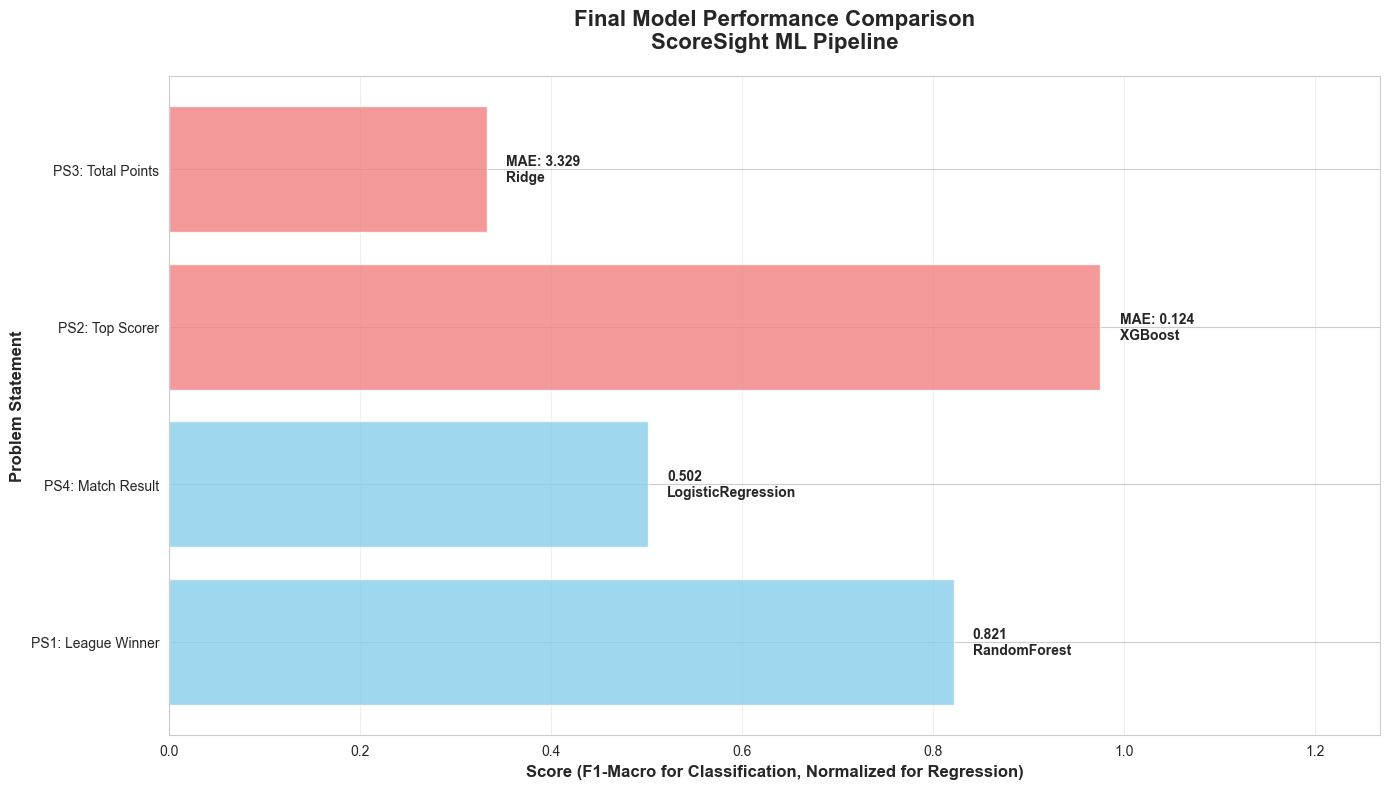


Performance comparison saved to: visualizations\final_model_performance_comparison.png
Training session summary saved to: reports\training_session_summary.json

MODEL TRAINING PIPELINE COMPLETE!

Models trained: 4
   PS1_League_Winner
   PS2_Top_Scorer
   PS3_Total_Points
   PS4_Match_Result

All outputs saved to:
   Models: models/
   Visualizations: visualizations/
   Reports: reports/


In [8]:
# ==================================================
# Cell 8: FINAL MODEL PERFORMANCE SUMMARY
# ==================================================

print("\n" + "=" * 100)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 100)

# Define paths to all metric files
METRICS_PATHS = {
    'PS1: League Winner': MODELS_DIR / 'ps1_league_winner_metadata.json',
    'PS2: Top Scorer': MODELS_DIR / 'ps2_top_scorer_metadata.json',
    'PS3: Total Points': MODELS_DIR / 'ps3_total_points_metadata.json',
    'PS4: Match Result': MODELS_DIR / 'ps4_match_result_metrics.json'
}

# Collect metrics
summary_data = []
print("\nLoading model metrics...\n")

for name, path in METRICS_PATHS.items():
    if not path.exists():
        print(f"  {name}: Metric file not found, skipping")
        continue
    
    try:
        with open(path, 'r') as f:
            metrics = json.load(f)
        
        # Extract best model name
        best_model = metrics.get('best_model', 'Unknown')
        
        # Extract primary metric based on problem type
        if 'PS1' in name or 'PS4' in name:
            # Classification
            metric_name = 'F1-Macro'
            score = None
            
            # Try different paths for the metric
            if 'models_attempted' in metrics and metrics['models_attempted']:
                for attempt in metrics['models_attempted']:
                    if attempt.get('model_name') == best_model:
                        score = attempt.get('test_metrics', {}).get('f1_macro')
                        break
            
            if score is None and 'test_metrics' in metrics:
                score = metrics['test_metrics'].get('f1_macro')
        
        elif 'PS2' in name or 'PS3' in name:
            # Regression
            metric_name = 'MAE'
            score = None
            
            if 'models_attempted' in metrics and metrics['models_attempted']:
                for attempt in metrics['models_attempted']:
                    if attempt.get('model_name') == best_model:
                        score = attempt.get('test_metrics', {}).get('mae')
                        break
            
            if score is None and 'test_metrics' in metrics:
                score = metrics['test_metrics'].get('mae')
        
        if score is not None:
            summary_data.append({
                'Problem': name,
                'Best Model': best_model,
                'Primary Metric': metric_name,
                'Score': float(score)
            })
            print(f"  {name}: {best_model} ({metric_name} = {score:.4f})")
        else:
            print(f"  {name}: Could not extract metric")
    
    except Exception as e:
        print(f"  {name}: Error loading - {e}")

# Create summary DataFrame
if summary_data:
    summary_df = pd.DataFrame(summary_data)
    
    print("\n" + "=" * 100)
    print("MODEL PERFORMANCE COMPARISON")
    print("=" * 100)
    print(summary_df.to_string(index=False))
    print("=" * 100)
    
    # Visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Separate by metric type
    classification_df = summary_df[summary_df['Primary Metric'] == 'F1-Macro']
    regression_df = summary_df[summary_df['Primary Metric'] == 'MAE']
    
    y_pos = []
    values = []
    colors = []
    labels = []
    
    if not classification_df.empty:
        for idx, row in classification_df.iterrows():
            y_pos.append(row['Problem'])
            values.append(row['Score'])
            colors.append('skyblue')
            labels.append(f"{row['Score']:.3f}\n{row['Best Model']}")
    
    if not regression_df.empty:
        # For MAE, normalize for visualization (lower is better)
        max_mae = regression_df['Score'].max()
        for idx, row in regression_df.iterrows():
            y_pos.append(row['Problem'])
            # Normalize: convert to 0-1 scale where 1 is best (0 MAE)
            normalized = 1 - (row['Score'] / (max_mae * 1.5))
            values.append(max(normalized, 0.1))  # Ensure visibility
            colors.append('lightcoral')
            labels.append(f"MAE: {row['Score']:.3f}\n{row['Best Model']}")
    
    bars = ax.barh(y_pos, values, color=colors, alpha=0.8)
    
    # Add labels
    for bar, label in zip(bars, labels):
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
               label, va='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Score (F1-Macro for Classification, Normalized for Regression)', 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('Problem Statement', fontsize=12, fontweight='bold')
    ax.set_title('Final Model Performance Comparison\nScoreSight ML Pipeline', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlim([0, max(values) * 1.3])
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    output_path = VIZ_DIR / 'final_model_performance_comparison.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPerformance comparison saved to: {output_path}")
    
    # Save training session summary
    session_path = REPORTS_DIR / 'training_session_summary.json'
    with open(session_path, 'w') as f:
        json.dump(TRAINING_SESSION, f, indent=2)
    
    print(f"Training session summary saved to: {session_path}")
    
else:
    print("\nNo model metrics were loaded. Training may not have completed successfully.")

print("\n" + "=" * 100)
print("MODEL TRAINING PIPELINE COMPLETE!")
print("=" * 100)
print(f"\nModels trained: {len(TRAINING_SESSION['models_trained'])}")
for model in TRAINING_SESSION['models_trained']:
    print(f"   {model}")

print(f"\nAll outputs saved to:")
print(f"   Models: {MODELS_DIR}/")
print(f"   Visualizations: {VIZ_DIR}/")
print(f"   Reports: {REPORTS_DIR}/")